# Sales Forecasting and Analysis for Rossmann Store Sales

## Introduction
This project focuses on analyzing and forecasting sales data for Rossmann stores using datasets provided by Kaggle. The objective is to build predictive models to forecast future sales and to gain insights into sales patterns across various stores. The analysis involves several key steps, including data preprocessing, feature engineering, the application of time series forecasting techniques and predictive model building.

Datasets Used:
train.csv: Contains historical sales data, including sales figures, customer counts, and store operational details.
store.csv: Provides metadata for each store, such as store type, assortment, and competition details.





In [1]:
# Installing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_regression
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import probplot, boxcox
import scipy.stats as stats
from numpy.fft import fft
import matplotlib.pyplot as plt
from scipy.signal import periodogram
from scipy.stats import chi2



## Data Exploration
In this section, we will load the datasets, explore their structure, and understand their content. Missing values are handled using median or mode imputation to maintain data integrity and the two dataset is merged. 


In [3]:
### 1. Load Data
# Load datasets 
train_df = pd.read_csv('train.csv', dtype={'StateHoliday': 'str', 'Sales': 'float64', 'Customers': 'int64', 'Open': 'int64'}, low_memory=False)
store_df = pd.read_csv('store.csv', dtype={'CompetitionDistance': 'float64', 'Promo2SinceYear': 'float64'}, low_memory=False)


In [4]:
### 2. Explore Data
print(train_df.info())
print(store_df.info())
# Impute missing values using median or mode, with loc 

train_df['StateHoliday'] = train_df['StateHoliday'].astype(str)

store_df.loc[:, 'CompetitionDistance'] = store_df['CompetitionDistance'].fillna(store_df['CompetitionDistance'].median())
store_df.loc[:, 'CompetitionOpenSinceMonth'] = store_df['CompetitionOpenSinceMonth'].fillna(store_df['CompetitionOpenSinceMonth'].mode()[0])
store_df.loc[:, 'CompetitionOpenSinceYear'] = store_df['CompetitionOpenSinceYear'].fillna(store_df['CompetitionOpenSinceYear'].mode()[0])
store_df.loc[:, 'Promo2SinceWeek'] = store_df['Promo2SinceWeek'].fillna(store_df['Promo2SinceWeek'].mode()[0])
store_df.loc[:, 'Promo2SinceYear'] = store_df['Promo2SinceYear'].fillna(store_df['Promo2SinceYear'].mode()[0])

# convert Date columns to datetime 
train_df['Date'] = pd.to_datetime(train_df['Date'])

print(train_df.info())
print(store_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   Store          1017209 non-null  int64  
 1   DayOfWeek      1017209 non-null  int64  
 2   Date           1017209 non-null  object 
 3   Sales          1017209 non-null  float64
 4   Customers      1017209 non-null  int64  
 5   Open           1017209 non-null  int64  
 6   Promo          1017209 non-null  int64  
 7   StateHoliday   1017209 non-null  object 
 8   SchoolHoliday  1017209 non-null  int64  
dtypes: float64(1), int64(6), object(2)
memory usage: 69.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 no

In [5]:
### 3. Merge Datasets
# List of months to create columns for
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

# Initialize new columns for each month with 0
for month in months:
    store_df[month] = 0

# Populate the new month columns based on PromoInterval
for i, row in store_df.iterrows():
    if pd.notnull(row['PromoInterval']):
        promo_months = row['PromoInterval'].split(',')
        for month in promo_months:
            store_df.at[i, month] = 1

# Drop the original PromoInterval column if no longer needed
store_df.drop('PromoInterval', axis=1, inplace=True)

# Merging datasets
merged_df = pd.merge(train_df, store_df, how='left', on='Store')


# Droping Open = 0, since if store is closed, makes no sense to see the sales
merged_df = merged_df[merged_df['Open'] == 1]
print(merged_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 844392 entries, 0 to 1017190
Data columns (total 29 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844392 non-null  int64         
 1   DayOfWeek                  844392 non-null  int64         
 2   Date                       844392 non-null  datetime64[ns]
 3   Sales                      844392 non-null  float64       
 4   Customers                  844392 non-null  int64         
 5   Open                       844392 non-null  int64         
 6   Promo                      844392 non-null  int64         
 7   StateHoliday               844392 non-null  object        
 8   SchoolHoliday              844392 non-null  int64         
 9   StoreType                  844392 non-null  object        
 10  Assortment                 844392 non-null  object        
 11  CompetitionDistance        844392 non-null  float64     

## Feature Engineering 
Feature engineering is crucial as it enhances Model Performance by creating relevant features that improve accuracy and reduce overfitting,
improves Interpretability by making it easier to understand how features affect predictions and identifies non-linear patterns and interactions between variables.

In [6]:
# Extract Date Features like Year, Month, Day, WeekOfYear to help in capturing seasonality and trends.
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week

# Lag features for time series forecasting.

merged_df['Sales_Lag1'] = merged_df.groupby('Store')['Sales'].shift(1)
merged_df['Sales_Lag7'] = merged_df.groupby('Store')['Sales'].shift(7)


# Encode Categorical Variables
# One-Hot Encoding for StoreType and Assortment
merged_df = pd.get_dummies(merged_df, columns=['Assortment'])
merged_df = pd.get_dummies(merged_df, columns=['StateHoliday'])

## Scaling
Scaling ensures that all features contribute equally to the analysis: normalization and standardization

In [6]:
# Initialize the scaler
scaler = StandardScaler()

# List of columns to scale 
columns_to_scale = ['Sales_Lag1', 'Sales_Lag7', 'CompetitionDistance', 'Customers']

# Apply scaling
merged_df[columns_to_scale] = scaler.fit_transform(merged_df[columns_to_scale])


## Time Series Modeling 

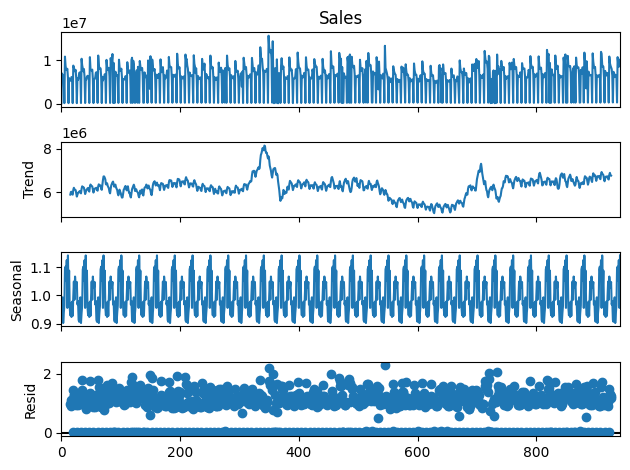

In [7]:
# time series decomposition 
daily_sales = merged_df.groupby('Date')['Sales'].sum().reset_index()

decomposition = seasonal_decompose(daily_sales['Sales'], model='multiplicative', period=30) # period can be adjusted
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
decomposition.plot()
plt.show()

Interpretation:
•	Trend Analysis: The trend component suggests that your sales experienced a significant increase at a certain point, possibly due to a major event or a period of high demand, followed by a more stable period.
•	Seasonality Analysis: The seasonal component shows consistent, predictable cycles in your sales data, which is crucial for understanding and predicting periods of high and low sales.
•	Residual Analysis: The residuals seem to be somewhat scattered, which is expected. However, you should ensure that there are no patterns in the residuals. If patterns exist, it might suggest that there are still unexplained structures in the data that your model has not captured.


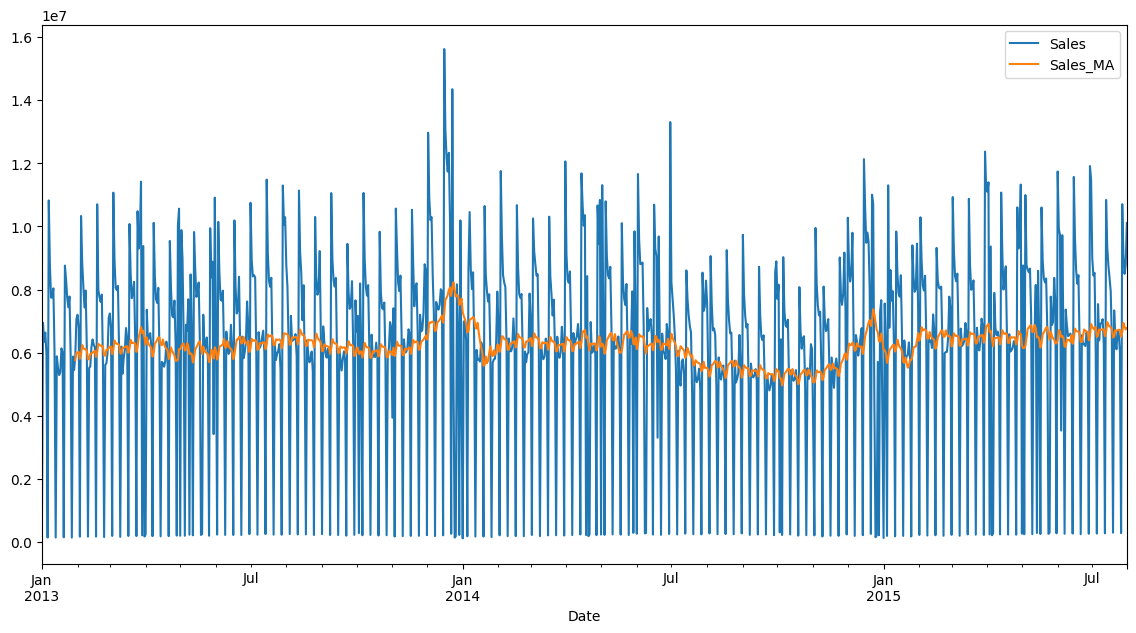

In [20]:
# trend detection 
daily_sales['Sales_MA'] = daily_sales['Sales'].rolling(window=30).mean()  # 30-day moving average
daily_sales[['Date', 'Sales', 'Sales_MA']].plot(x='Date', figsize=(14,7))
plt.show()


Interpretation: <br>
•	Fluctuations in Sales: The blue line (Sales) shows considerable day-to-day variability, with peaks and troughs that may correspond to specific events, holidays, or promotions.
•	Trend Over Time: The orange line (Sales_MA) provides a clearer view of the trend over time. It shows how the average sales have changed throughout the period. For instance:
o	Early 2014: There seems to be a dip in the sales trend which shows a period of lower average sales.
o	Mid 2014 to 2015: The trend appears to stabilize with some minor fluctuations, which could mean a steady sales period with minor ups and downs.
•	Comparison to Sales: The moving average (orange) line stays below the peaks and above the troughs of the actual sales data, as expected and this line is useful for identifying the general direction in which sales are moving, without being distracted by daily noise.


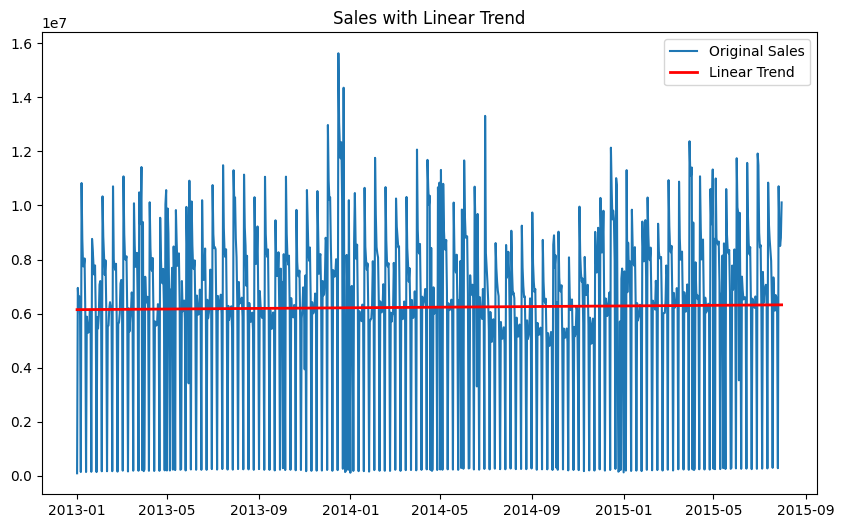

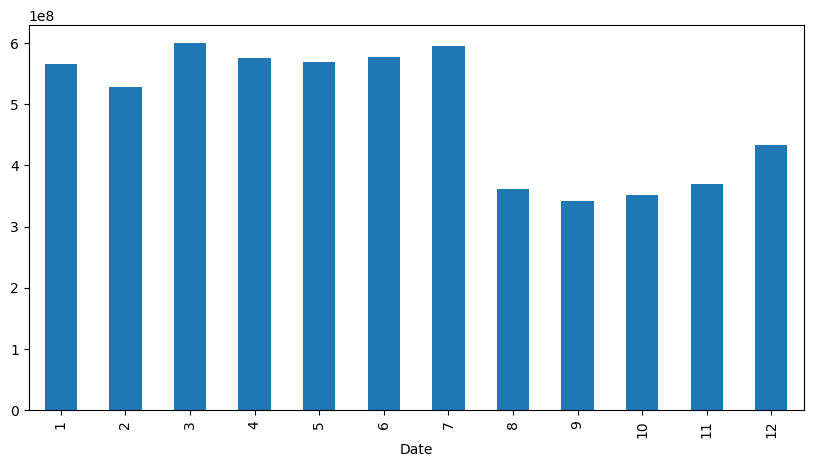

In [64]:
# Prepare the data
daily_sales['Date_ordinal'] = pd.to_datetime(daily_sales['Date']).map(lambda date: date.toordinal())
X = daily_sales['Date_ordinal'].values.reshape(-1, 1)
y = daily_sales['Sales'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)

#the original data and the trend line
plt.figure(figsize=(10,6))
plt.plot(daily_sales['Date'], daily_sales['Sales'], label='Original Sales')
plt.plot(daily_sales['Date'], trend, color='red', label='Linear Trend', linewidth=2)
plt.legend()
plt.title('Sales with Linear Trend')
plt.show()

# Seasonlity detection 
monthly_sales = merged_df.groupby(merged_df['Date'].dt.month)['Sales'].sum()
monthly_sales.plot(kind='bar', figsize=(10,5))
plt.show()

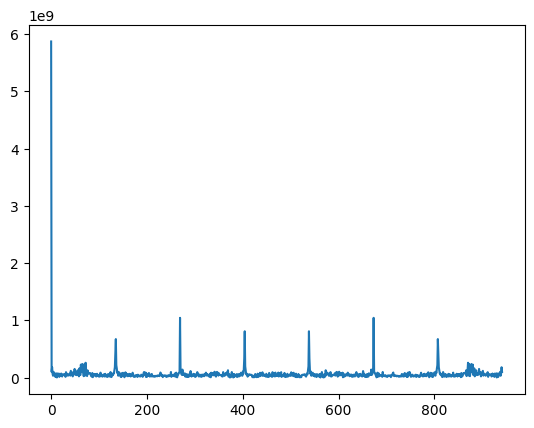

In [15]:
# Fourier transform to detect cycles within the data.
sales_fft = fft(daily_sales['Sales'])
plt.plot(np.abs(sales_fft))
plt.show()


Interpretation: <br>
Peaks and Spikes:
The plot shows several sharp spikes at regular intervals, with one particularly large spike at the beginning and the spikes indicate events or anomalies where the value of the variable suddenly increases. The first spike is significantly larger than the others, which shows  a major event or anomaly at that point. <br>
Baseline Fluctuations:
Between the spikes, the values remain relatively low but not flat, which shows some minor fluctuations in the variable. <br>
Possible Periodicity:
The regular spacing of the spikes suggests a periodic pattern.

ADF Statistic: -4.761614524595621
p-value: 6.436731330559149e-05
KPSS Statistic: 0.2050744062408723
p-value: 0.1


/var/folders/pm/nf1w4zt564sb4_g85jb0yg_m0000gn/T/ipykernel_37173/635385903.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(daily_sales['Sales'], regression='c')


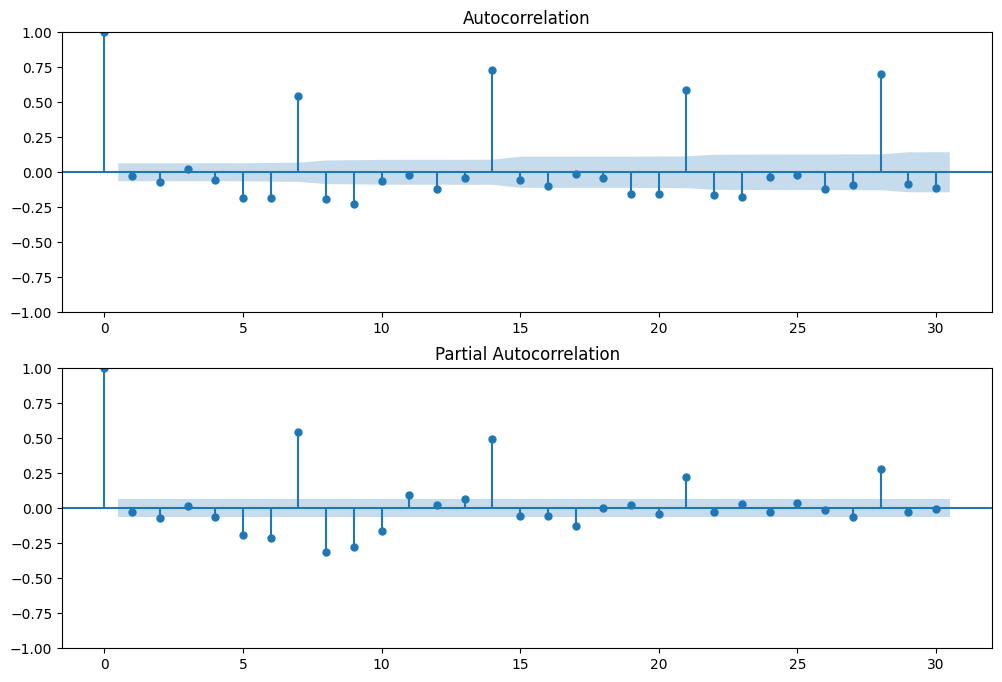

In [22]:
# SARIMA to Predict future sales considering both trend and seasonality.

# test for stationary 
# ADF Test
adf_result = adfuller(daily_sales['Sales'])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

# KPSS Test
from statsmodels.tsa.stattools import kpss
kpss_result = kpss(daily_sales['Sales'], regression='c')
print('KPSS Statistic:', kpss_result[0])
print('p-value:', kpss_result[1])

# ACF and PACF plots
fig, ax = plt.subplots(2, figsize=(12,8))

plot_acf(daily_sales['Sales'].dropna(), ax=ax[0])
plot_pacf(daily_sales['Sales'].dropna(), ax=ax[1])

plt.show()

Since for Sarima trend has to be stationary and since both the ADF and KPSS tests suggest that time series is stationary, differencing not required. <br>
Determining the Orders:<br>
Non-Seasonal Components: <br>
•	p (AR order): Since there's a significant spike at lag 1 in the PACF plot,  p=1. <br>
•	q (MA order): Since there's a significant spike at lag 1 in the ACF plot, q=1. <br>
•	d (Differencing order): Since the series is stationary, set d=0. <br>
Seasonal Components: <br>
•	P (Seasonal AR order): The PACF shows a moderate spike at lag 12, suggesting a seasonal AR component. P=1. <br>
•	Q (Seasonal MA order): The ACF also shows a spike at lag 12,  Q=1. <br>
•	D (Seasonal differencing order): Since the series seems stationary, set D=0. <br>
•	s (Seasonal Periodicity): Given the spikes around lag 12, the seasonality might be 12 months so set s=12. <br>


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62251D+01    |proj g|=  6.83800D-01


 This problem is unconstrained.



At iterate    5    f=  1.61882D+01    |proj g|=  2.67736D-01

At iterate   10    f=  1.61538D+01    |proj g|=  1.58742D+00

At iterate   15    f=  1.61453D+01    |proj g|=  1.15173D-01

At iterate   20    f=  1.61438D+01    |proj g|=  2.41503D-01

At iterate   25    f=  1.61436D+01    |proj g|=  3.10056D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     49      1     0     0   3.101D-05   1.614D+01
  F =   16.143628716872101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                                     SARIMAX Results                                      
Dep. Variable:        

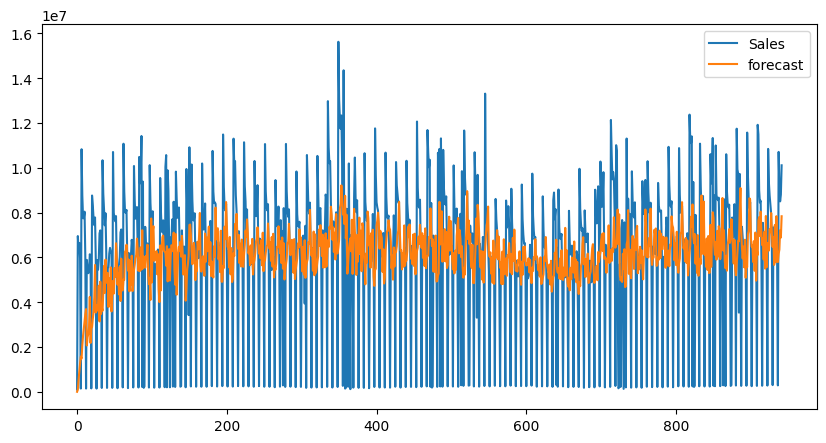

In [23]:
# the SARIMA model
model = SARIMAX(daily_sales['Sales'], 
                order=(1, 0, 1), 
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)

# Fit the model

results = model.fit()
print(results.summary())
daily_sales['forecast'] = results.predict(start=0, end=len(daily_sales)-1, dynamic=False)
daily_sales[['Sales', 'forecast']].plot(figsize=(10,5))
plt.show()

Model Summary Interpretation: <br>
1.	Parameters: <br>
	ar.L1, ma.L1, ar.S.L12, ma.S.L12: are the coefficients for the AR (autoregressive), MA (moving average), seasonal AR, and seasonal MA components, respectively and the coefficients are statistically significant, as indicated by the very small p-values (all are 0.000). This means that these terms contribute significantly to the model. <br>
2.	AIC/BIC/HQIC: <br>
	These are model selection criteria (Akaike Information Criterion, Bayesian Information Criterion, and Hannan-Quinn Information Criterion). Lower values generally indicate a better fit of the model.
3.	Residual Diagnostics: <br>
	Ljung-Box (L1): This tests for autocorrelation in the residuals. A p-value above 0.05 would suggest no significant autocorrelation.  <br>
	Heteroskedasticity (H): This tests for the presence of non-constant variance in the residuals.  <br>
	Jarque-Bera (JB): This is a test for normality of the residuals. A significant p-value suggests that the residuals are not normally distributed.  <br>
Here , some diagnostic metrics like the Jarque-Bera test are significant (p-value 0.00), indicating that the residuals might not be normally distributed.


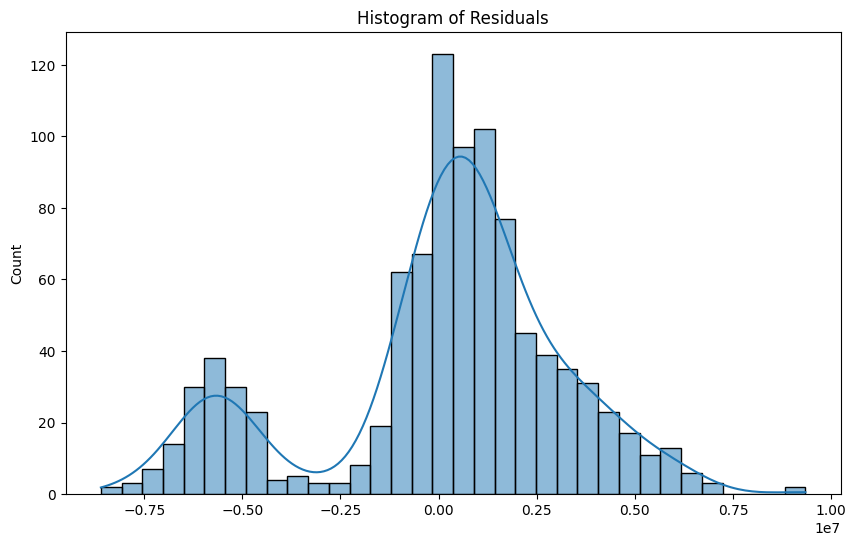

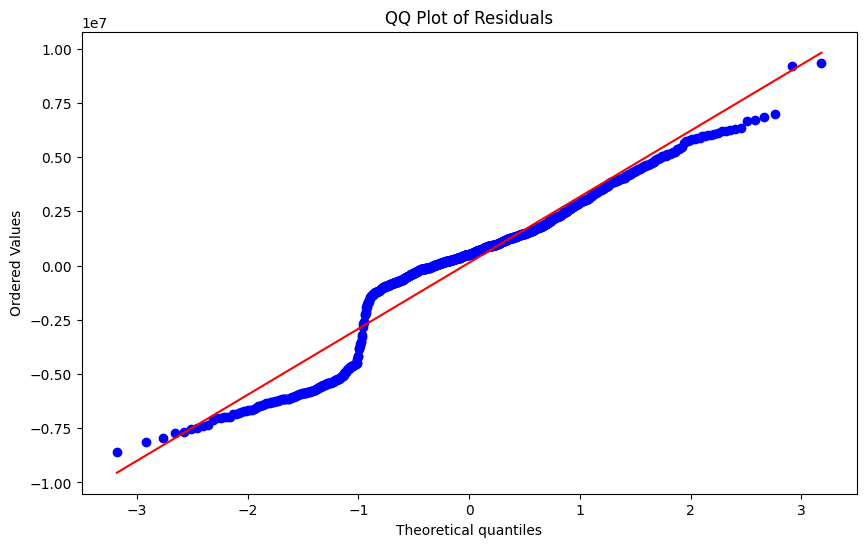

In [24]:
### check the residue since forcast closelsy follows the data, so like overfitting
# Extracting the residuals from the fitted model
residuals = results.resid

# Plot residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.show()

# QQ-Plot
plt.figure(figsize=(10,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals')
plt.show()


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64394D+01    |proj g|=  6.80052D-01

At iterate    5    f=  1.64079D+01    |proj g|=  1.46481D+00

At iterate   10    f=  1.63621D+01    |proj g|=  1.04022D+00

At iterate   15    f=  1.63608D+01    |proj g|=  1.33909D-01

At iterate   20    f=  1.63584D+01    |proj g|=  2.13778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     47      1     0     0   4.543D-04   1.636D+01
  F =   16.358446453135834     

CONVERG

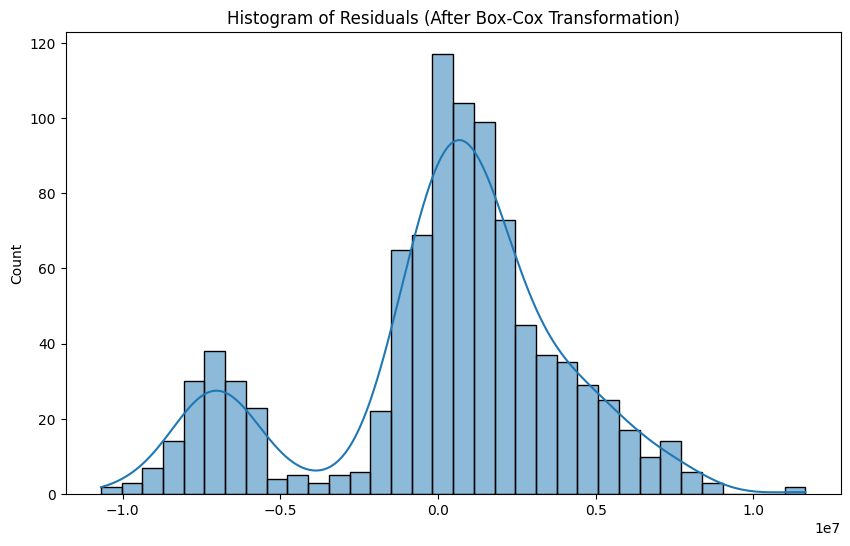

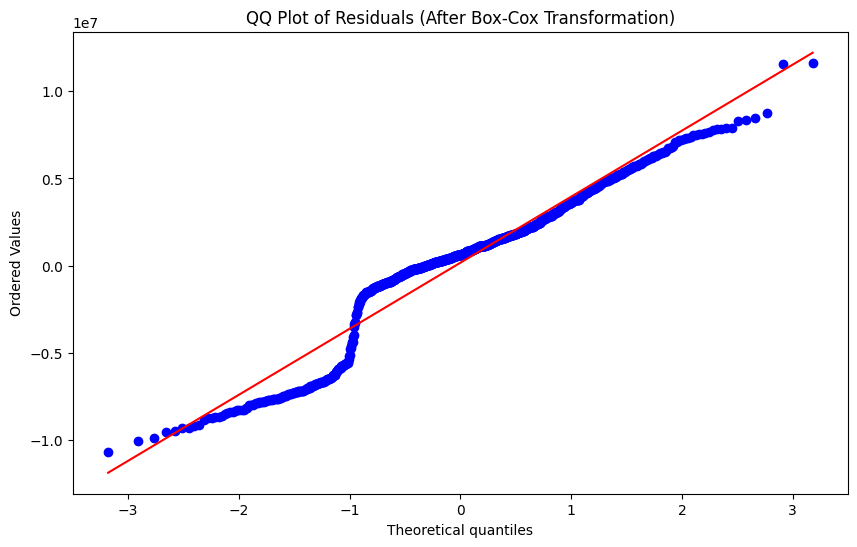

Fitted Lambda for Box-Cox Transformation: 1.014357503275078


In [25]:
# Box-Cox transformation
daily_sales['BoxCox_Sales'], fitted_lambda = boxcox(daily_sales['Sales'] + 1)  # Adding 1 to handle zeros

# Fit SARIMA model on Box-Cox transformed data
model = SARIMAX(daily_sales['BoxCox_Sales'], 
                order=(1, 0, 1), 
                seasonal_order=(1, 0, 1, 12),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit()

#the residuals
residuals = results.resid

# histogram of residuals
plt.figure(figsize=(10,6))
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals (After Box-Cox Transformation)')
plt.show()

# QQ-Plot
plt.figure(figsize=(10,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ Plot of Residuals (After Box-Cox Transformation)')
plt.show()

#  the fitted lambda
print("Fitted Lambda for Box-Cox Transformation:", fitted_lambda)

## normality is better but not fixed. 

Predominant Frequency: 0.28556263269639065
Spectral Density at Predominant Frequency: 3174661189750.6514
95% Confidence Interval: [80375462417.28424, 11710942436644.08]


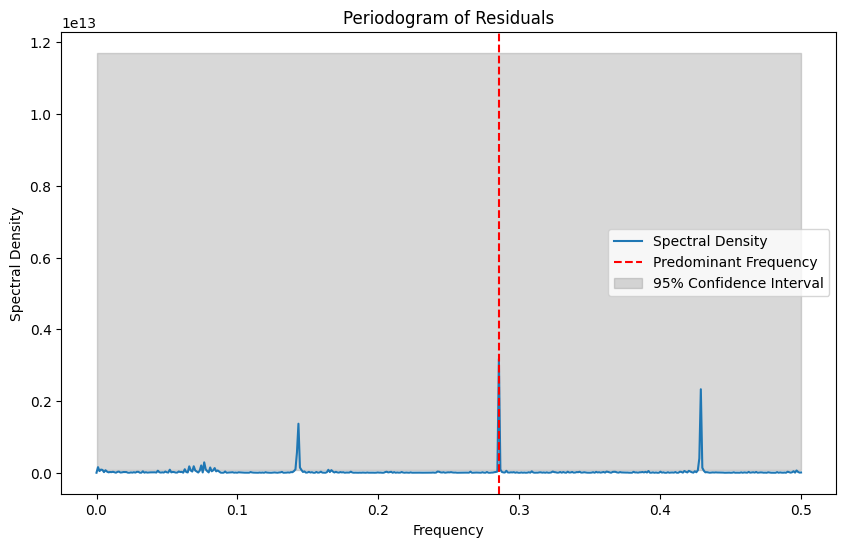

In [26]:
# After the box-cox spectral Analysis
# Extract residuals from SARIMA model
residuals = results.resid

# Compute the periodogram (spectral density)
frequencies, spectral_density = periodogram(residuals, scaling='spectrum')

# the predominant frequency
predominant_freq_index = np.argmax(spectral_density)
predominant_frequency = frequencies[predominant_freq_index]
max_spectral_density = spectral_density[predominant_freq_index]

# confidence intervals for the spectral density
alpha = 0.05  # 95% confidence level
dof = 2  # Degrees of freedom for the periodogram

# confidence interval
lower_bound = max_spectral_density * chi2.ppf(alpha / 2, dof) / dof
upper_bound = max_spectral_density * chi2.ppf(1 - alpha / 2, dof) / dof

# the results
print(f"Predominant Frequency: {predominant_frequency}")
print(f"Spectral Density at Predominant Frequency: {max_spectral_density}")
print(f"95% Confidence Interval: [{lower_bound}, {upper_bound}]")

# the periodogram with confidence intervals
plt.figure(figsize=(10, 6))
plt.plot(frequencies, spectral_density, label='Spectral Density')
plt.axvline(predominant_frequency, color='r', linestyle='--', label='Predominant Frequency')
plt.fill_between(frequencies, lower_bound, upper_bound, color='gray', alpha=0.3, label='95% Confidence Interval')
plt.xlabel('Frequency')
plt.ylabel('Spectral Density')
plt.title('Periodogram of Residuals')
plt.legend()
plt.show()


Based on the spectral analysis of the residuals from the SARIMA model: <br>

Predominant Frequency: The predominant frequency identified is approximately 0.2856. This frequency represents the cycle or periodicity in the residuals of the model that occurs most frequently. A frequency of 0.2856 suggests a cycle that repeats approximately every 3.5 time units. <br>
Spectral Density at Predominant Frequency: The spectral density at this predominant frequency is approximately 3.17 × 10¹². This value indicates the magnitude of variation at this frequency, meaning that this is where most of the energy or variability in the residuals is concentrated. <br>
95% Confidence Interval: The 95% confidence interval for the spectral density at the predominant frequency is [8.04 × 10¹⁰, 1.17 × 10¹³]. This wide confidence interval suggests that there is a significant amount of uncertainty or variability in estimating the spectral density at the dominant frequency. The interval represents the range within which the true spectral density at the dominant frequency is likely to fall with 95% confidence. <br>
<br>
Key Points: <br>
Statistical Significance: The lower bound of the confidence interval (8.04 × 10¹⁰) is significantly higher than the spectral density at most other frequencies (which are not mentioned but typically would be much lower), indicating that the peak at the dominant frequency is substantially higher than the background spectral noise. This implies that the peak is statistically significant, meaning that the cyclic behavior at this frequency is a real feature in the data rather than random noise. <br>
Fitted Lambda for Box-Cox Transformation: The fitted lambda for the Box-Cox transformation is approximately 1.0144, which is very close to 1. This indicates that the data was nearly linear already, and the transformation has only slightly adjusted the data to stabilize variance and make it more suitable for modeling. <br>
<br>
Conclusion:
The predominant frequency of 0.2856 with a significant spectral density and a wide confidence interval suggests that there is a meaningful cyclical component in the data at this frequency. The analysis indicates that this cycle is likely to be a genuine feature rather than noise, and any future modeling or analysis should take this into account. 

## Model Building 


### Sales Analysis 

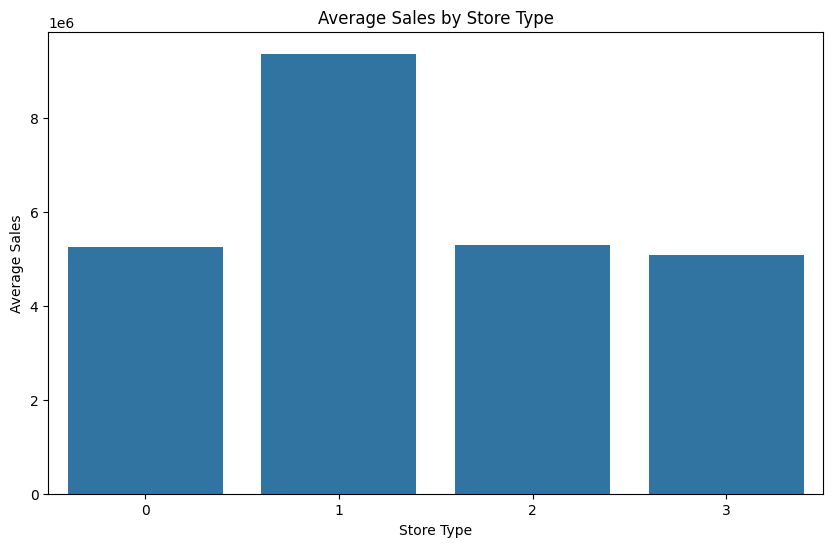

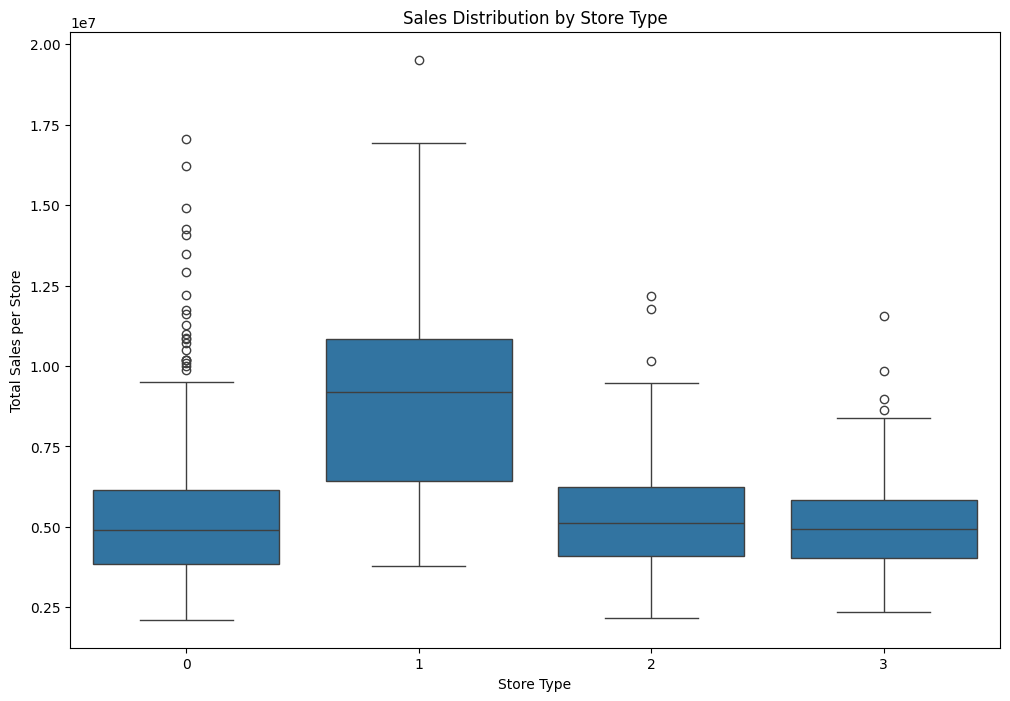

In [8]:
# Label encode the StoreType column
label_encoder = LabelEncoder()
merged_df['StoreType'] = label_encoder.fit_transform(merged_df['StoreType'])

# Proceed with your analysis or modeling
# Example: Aggregating total sales by store
store_sales = merged_df.groupby(['Store', 'StoreType'])['Sales'].sum().reset_index()

# Aggregate average sales by store type
store_type_sales = store_sales.groupby('StoreType')['Sales'].mean().reset_index()

# Bar Plot for Average Sales by Store Type:
plt.figure(figsize=(10,6))
sns.barplot(x='StoreType', y='Sales', data=store_type_sales)
plt.title('Average Sales by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Average Sales')
plt.show()

# Box Plot to Show Distribution of Sales within Each Store Type:
plt.figure(figsize=(12,8))
sns.boxplot(x='StoreType', y='Sales', data=store_sales)
plt.title('Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Total Sales per Store')
plt.show()

In [74]:
# Display unique columns
print(merged_df.columns.unique())

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StoreType', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'Jan', 'Feb', 'Mar', 'Apr', 'May',
       'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec', 'Year', 'Month',
       'Day', 'WeekOfYear', 'Sales_Lag1', 'Sales_Lag7', 'Assortment_a',
       'Assortment_b', 'Assortment_c', 'StateHoliday_0', 'StateHoliday_a',
       'StateHoliday_b', 'StateHoliday_c'],
      dtype='object')


### Sales Analysis for different stores. 

/var/folders/pm/nf1w4zt564sb4_g85jb0yg_m0000gn/T/ipykernel_63067/2828229702.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_stores = store_sales.groupby('StoreType').apply(lambda x: x.nlargest(5, 'Sales')).reset_index(drop=True)


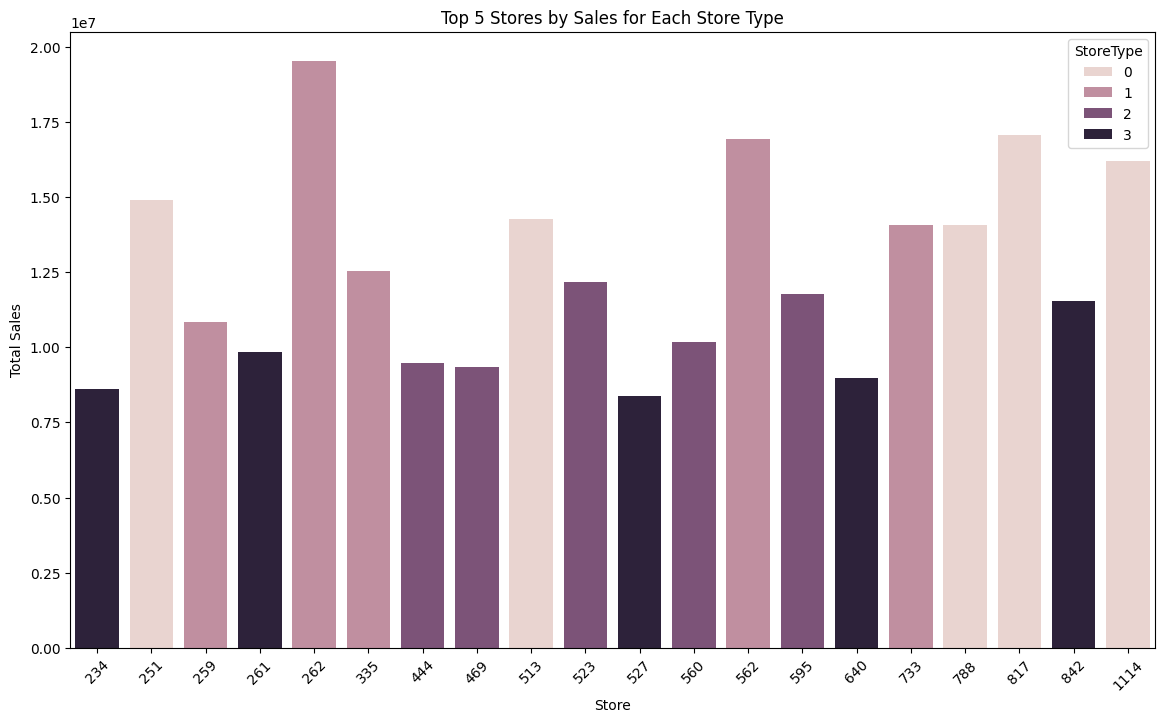

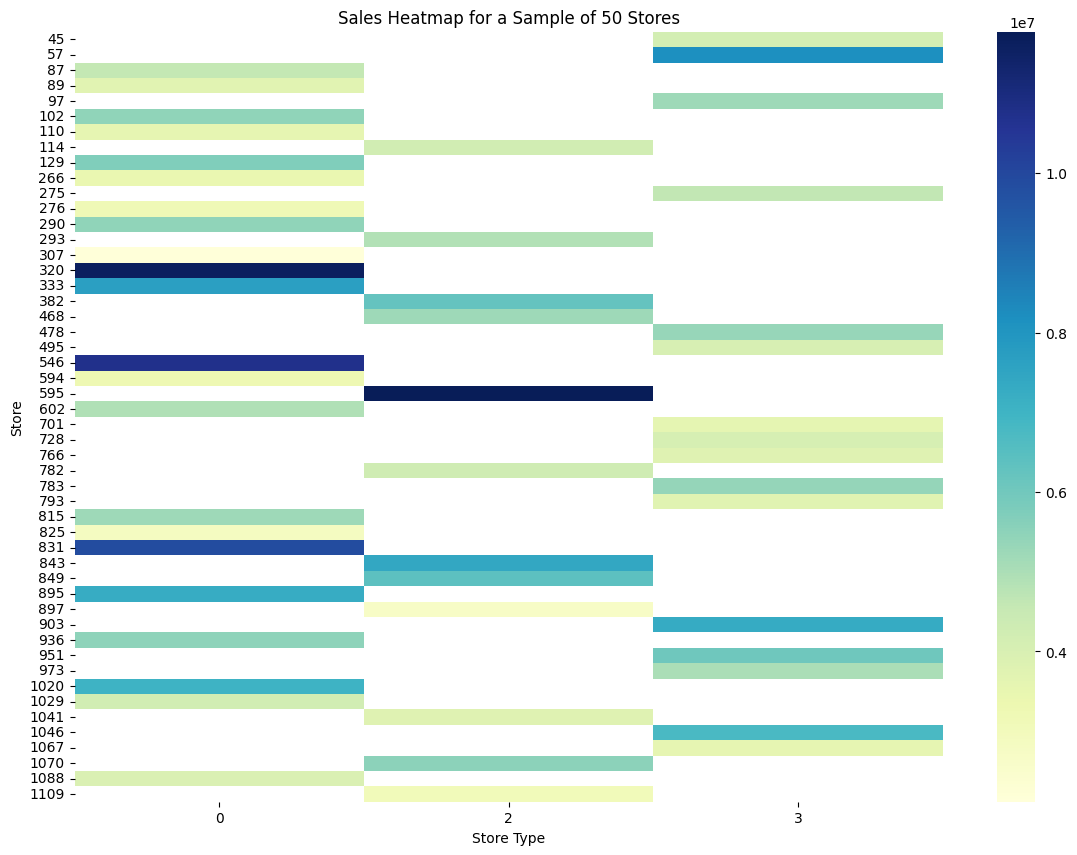

In [9]:
# Top 5 Stores by Sales from Each Store Type
top_stores = store_sales.groupby('StoreType').apply(lambda x: x.nlargest(5, 'Sales')).reset_index(drop=True)

plt.figure(figsize=(14,8))
sns.barplot(x='Store', y='Sales', hue='StoreType', data=top_stores)
plt.title('Top 5 Stores by Sales for Each Store Type')
plt.xlabel('Store')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.show()

# Heatmap for Sales Performance Across a Selection of Stores:
# a sample of 50 stores to avoid overcrowding
sampled_stores = store_sales.sample(50, random_state=42)

#data for the heatmap
sales_pivot = sampled_stores.pivot(index="Store", columns="StoreType", values="Sales")

#heatmap
plt.figure(figsize=(14,10))
sns.heatmap(sales_pivot, annot=False, cmap="YlGnBu")
plt.title('Sales Heatmap for a Sample of 50 Stores')
plt.xlabel('Store Type')
plt.ylabel('Store')
plt.show()


<IntegerArray>
[31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13,
 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 52, 51, 50, 49, 48, 47, 46,
 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32]
Length: 52, dtype: UInt32

Key Considerations:<br>
<br>
Lag Features Are Still Valuable: Lag features can capture important temporal patterns within each store, such as how sales on a particular day are influenced by sales on the previous day or the same day of the previous week. <br>
Group-wise Splitting: When splitting the dataset, we want to maintain the integrity of the time series within each store. This means that for each store, the model should be trained on past data and tested on future data.
<br>
Best Approach: Group-wise Time-Based Splitting
And then perform a group-wise time-based split, where we split the data by time while keeping the data for each store together.
Group the Data by Store: Ensure that the data is grouped by store, so that when we split the data, each group (store) is treated independently.
Split by Time Within Each Store: For each store, use a time-based split. 

In [10]:
merged_df = merged_df.fillna(0)

# List of columns to include in X
feature_columns = [
    'Store', 'DayOfWeek', 'Customers', 'Open', 'Promo', 'StateHoliday_a',
    'StateHoliday_b', 'StateHoliday_c', 'SchoolHoliday', 'StoreType', 'Assortment_a', 
    'Assortment_b', 'Assortment_c', 'CompetitionDistance', 'Promo2', 
    'Promo2SinceWeek', 'Promo2SinceYear', 'Sales_Lag1', 'Sales_Lag7', 
    'Month', 'Year', 'WeekOfYear'
]

# the feature matrix X
X = merged_df[feature_columns]

y = merged_df['Sales']


# Apply SelectKBest to extract the top 10 features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
X_reduced = bestfeatures.fit_transform(X, y)

# mask of selected features
selected_features_mask = bestfeatures.get_support()

selected_features = np.array(X.columns)[selected_features_mask]

print("Selected features are:", selected_features)


# Key Considerations:
# Lag Features Are Still Valuable: Lag features can capture important temporal patterns within each store, such as how sales on a particular day are influenced by sales on the previous day or the same day of the previous week. 
# Group-wise Splitting: When splitting the dataset, we want to maintain the integrity of the time series within each store. This means that for each store, the model should be trained on past data and tested on future data.
# Best Approach: Group-wise Time-Based Splitting
# And then perform a group-wise time-based split, where we split the data by time while keeping the data for each store together.
# Group the Data by Store: Ensure that the data is grouped by store, so that when we split the data, each group (store) is treated independently.
# Split by Time Within Each Store: For each store, use a time-based split. 
# # Initialize lists to hold training and testing data
X_train_list = []
X_test_list = []
y_train_list = []
y_test_list = []
# Looping through each store
for store_id in merged_df['Store'].unique():
    store_data = merged_df[merged_df['Store'] == store_id]
    
    # putting the index for splitting based on time for this store
    split_index = int(len(store_data) * 0.8)
    
    # then split the data for this store
    X_train_list.append(store_data.iloc[:split_index].drop('Sales', axis=1))
    X_test_list.append(store_data.iloc[split_index:].drop('Sales', axis=1))
    y_train_list.append(store_data.iloc[:split_index]['Sales'])
    y_test_list.append(store_data.iloc[split_index:]['Sales'])


X_train = pd.concat(X_train_list)
X_test = pd.concat(X_test_list)
y_train = pd.concat(y_train_list)
y_test = pd.concat(y_test_list)

# Droping 'Store' column from X_train and X_test
X_train = X_train.drop(columns=['Store'])
X_test = X_test.drop(columns=['Store'])

# Ensure X_train and X_test have the same columns (selected features)
X_train = X_train[selected_features]
X_test = X_test[selected_features]

#missing values in lag features in X_train
X_train['Sales_Lag1'].fillna(0, inplace=True)
X_train['Sales_Lag7'].fillna(0, inplace=True)




Selected features are: ['DayOfWeek' 'Customers' 'Promo' 'Assortment_a' 'Assortment_c' 'Promo2'
 'Sales_Lag1' 'Sales_Lag7' 'Month' 'WeekOfYear']


/var/folders/pm/nf1w4zt564sb4_g85jb0yg_m0000gn/T/ipykernel_63067/76088454.py:71: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train['Sales_Lag1'].fillna(0, inplace=True)
/var/folders/pm/nf1w4zt564sb4_g85jb0yg_m0000gn/T/ipykernel_63067/76088454.py:72: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

### Random Forest Regressor
The Random Forest Regressor is an ensemble learning model that consists of multiple decision trees. Each tree is built on a random subset of the data and features, and the final prediction is made by averaging the predictions of all the trees and this randomness helps to reduce overfitting and improves generalization.

In [11]:
# Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
rf_model.fit(X_train, y_train)

# predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# metrics for Random Forest
mae_rf = mean_absolute_error(y_test, y_pred_rf)
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf) * 100  # R² score as a percentage



### Gradient Boosting Regressor
The Gradient Boosting Regressor is an ensemble machine learning model that builds multiple decision trees sequentially. Each new tree is trained to correct the errors made by the previous trees, with the goal of minimizing the overall prediction error.


In [12]:
# Convert boolean columns to integers
X_train['Assortment_a'] = X_train['Assortment_a'].astype(int)
X_train['Assortment_c'] = X_train['Assortment_c'].astype(int)
X_test['Assortment_a'] = X_test['Assortment_a'].astype(int)
X_test['Assortment_c'] = X_test['Assortment_c'].astype(int)


# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# metrics for Gradient Boosting
mae_gb = mean_absolute_error(y_test, y_pred_gb)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb) * 100  # R² score as a percentage




### ElasticNet
The Elastic Net is a linear regression model that combines the penalties of both the Lasso and Ridge regression methods. It aims to improve prediction accuracy by enforcing sparsity (selecting only the most important features) through L1 regularization (like Lasso) and by shrinking coefficients to prevent overfitting through L2 regularization (like Ridge). 

In [14]:
# Elastic Net Regressor
en_model = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
en_model.fit(X_train, y_train)

# Predictions on the test set
y_pred_en = en_model.predict(X_test)

# Calculate metrics for Elastic Net
mae_en = mean_absolute_error(y_test, y_pred_en)
mse_en = mean_squared_error(y_test, y_pred_en)
rmse_en = np.sqrt(mse_en)
r2_en = r2_score(y_test, y_pred_en) * 100  # R² score as a percentage



In [15]:
# Print the accuracy as a percentage
print("Random Forest Regressor Accuracy: {:.2f}%".format(r2_rf))
print("Gradient Boosting Regressor Accuracy: {:.2f}%".format(r2_gb))
print("Elastic Net Regressor Accuracy: {:.2f}%".format(r2_en))


results_df = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting Regressor', 'ElasticNet Regression'],
    'MAE': [mae_rf, mae_gb, mae_en],
    'MSE': [mse_rf, mse_gb, mse_en],
    'RMSE': [rmse_rf, rmse_gb, rmse_en],
    'R^2 (%)': [r2_rf, r2_gb, r2_en]
})
print(results_df)

Random Forest Regressor Accuracy: 83.71%
Gradient Boosting Regressor Accuracy: 90.27%
Elastic Net Regressor Accuracy: 81.75%
                         Model         MAE           MSE         RMSE  \
0                Random Forest  896.115538  1.476914e+06  1215.283619   
1  Gradient Boosting Regressor  686.099355  8.821188e+05   939.211815   
2        ElasticNet Regression  940.002315  1.654619e+06  1286.320118   

     R^2 (%)  
0  83.705704  
1  90.267881  
2  81.745143  


## Demand Forescasting


According to the table, Gradient Boosting Regressor is the best model among the three, as it has the highest R² score (indicating the best fit), the lowest MAE (indicating the smallest average error), and the lowest RMSE (indicating the best overall accuracy).


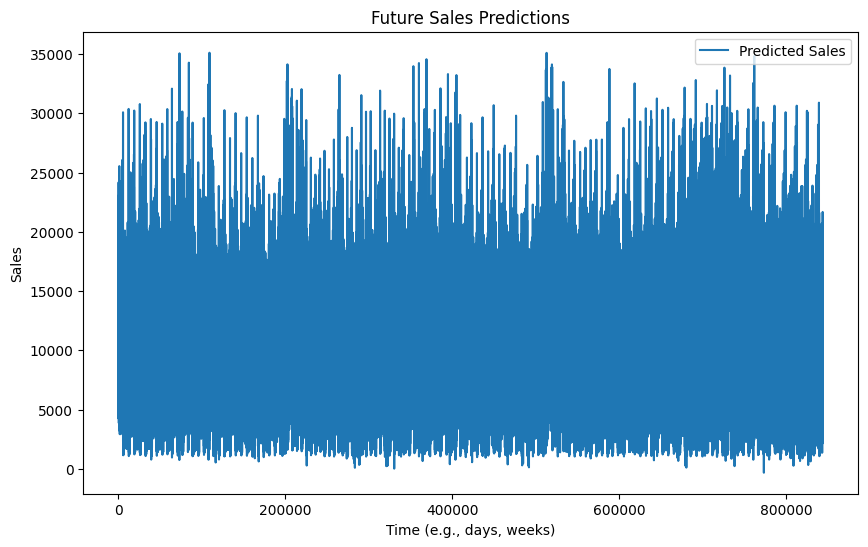

In [16]:
# Re-train the Gradient Boosting Regressor on the entire dataset
gbr_model = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gbr_model.fit(X_reduced, y)
              
future_sales_predictions = gbr_model.predict(X_reduced)

# Plotting the predicted future sales
plt.figure(figsize=(10,6))
plt.plot(future_sales_predictions, label='Predicted Sales')
plt.title('Future Sales Predictions')
plt.xlabel('Time (e.g., days, weeks)')
plt.ylabel('Sales')
plt.legend()
plt.show()


## Conclusions and Insights:

In this project, we applied time series analysis and predictive modeling to forecast sales. The time series analysis revealed a significant cyclical pattern, which was accounted for in the models. <br>
<br>
Among the models tested: <br>
<br>
Gradient Boosting Regressor performed the best with a MAE of 686.10 and an R² of 90.27%, making it the most accurate model for this dataset. Random Forest Regressor also showed strong performance with an R² of 83.71%, though it was slightly less accurate than Gradient Boosting. ElasticNet Regression lagged behind, with an R² of 81.75%, indicating that linear models may not be sufficient for capturing the complexities in the data. The variability in the RMSE values across models suggests some differences in their ability to capture underlying patterns accurately. Despite this, the identified cyclical patterns were significant, and the Gradient Boosting Regressor was effective in leveraging these patterns for accurate predictions.
<br>
Overall, the Gradient Boosting Regressor is recommended for future sales forecasting tasks, especially when non-linear and cyclical components are present in the data.